In [11]:
import sys 
import os 
sys.path.append(os.path.abspath("../"))
from src.Limma import batchEffectCorrection
from src.MetNormalizer import MetNorm
from utils.utility_functions import pca_plot,detection,TIC
import pandas as pd
import numpy as np
from inmoose.pycombat import pycombat_norm

removing blanks
returning accepted signals


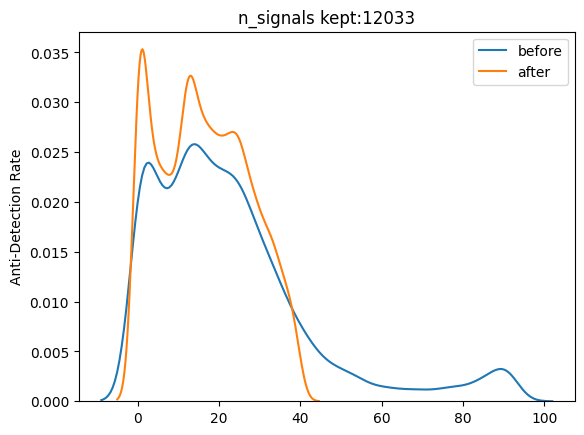

In [12]:
D = pd.read_csv("Data/2-peak_area_after_filling_missing_values.csv").set_index("position").drop(columns=['mz','rt','name']).T
M = pd.read_csv("Data/sample_metadata_all_batches.csv").set_index("sample_name")
D = D[~D.index.str.contains("_B_")]
M = M[~M.index.str.contains("_B_")]
D = D.drop(index='AOU_S_0104')
M = M.drop(index='AOU_S_0104')
D = D[detection(D,limit=0.40).index]
D = TIC(D,scale=True)
D = np.log2(D)

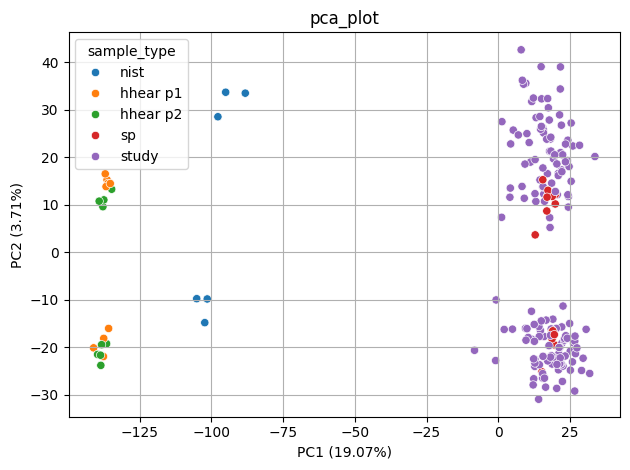

In [13]:
pca_plot(D,M)

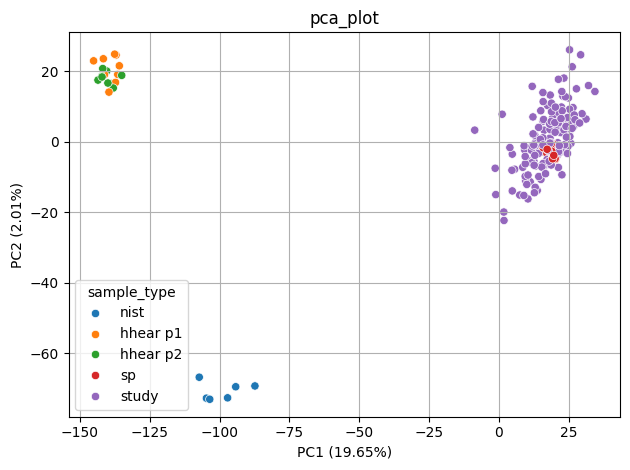

In [14]:
batch = M.loc[D.index,'batch']
combat = pycombat_norm(D.T,batch).T
pca_plot(combat,M)

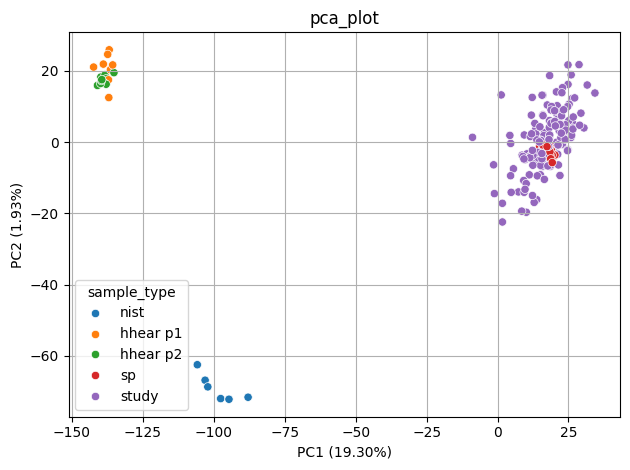

In [15]:
limma = batchEffectCorrection(D.T,M)
pca_plot(limma,M,hue='sample_type')

In [16]:
limmar = pd.read_csv("Data/limma_ref.csv").rename(columns={"Unnamed: 0":"name"}).set_index("name").T

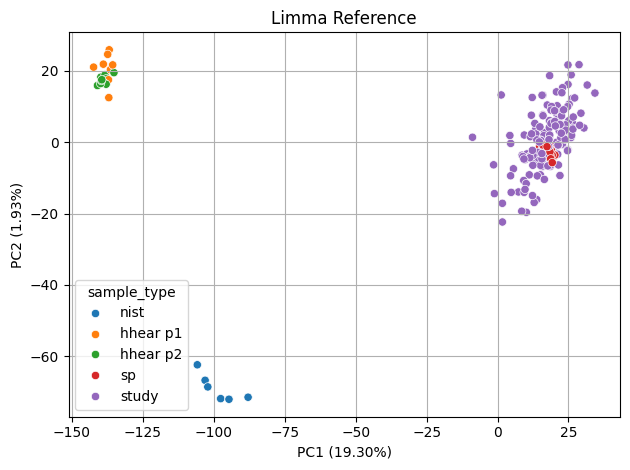

In [17]:
pca_plot(limmar,M,title='Limma Reference')

## MetNormalizer 

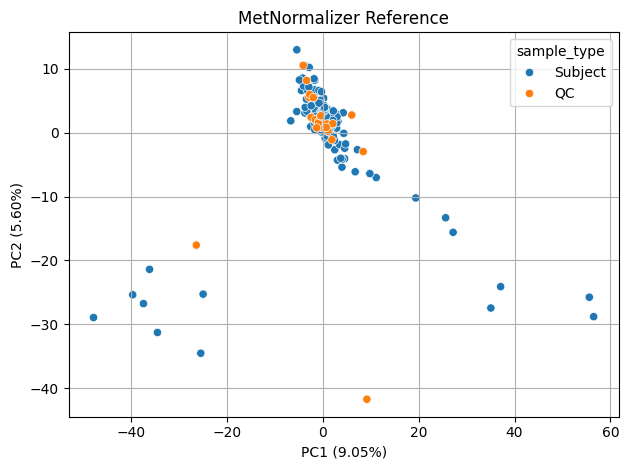

In [18]:
D = pd.read_csv("Data/metnor.csv").drop(columns=["mz",'rt']).set_index("name").T
M = pd.read_csv("Data/sample.info.csv").rename(columns={"sample.name":"sample_name","class":"sample_type"}).set_index("sample_name")
metNor = pd.read_csv("Data/data_svr_normalization.csv").drop(columns=["Unnamed: 0",'mz','rt','sample.nor.rsd','QC.nor.rsd']).set_index("name")
pca_plot(metNor.T,M,title='MetNormalizer Reference')

In [19]:
D.index= D.index.str.replace("QC","_SP_")
metnorm = MetNorm(D,M,cv=False)
results = metnorm.fit_transform()
results.index = results.index.str.replace("_SP_","QC")

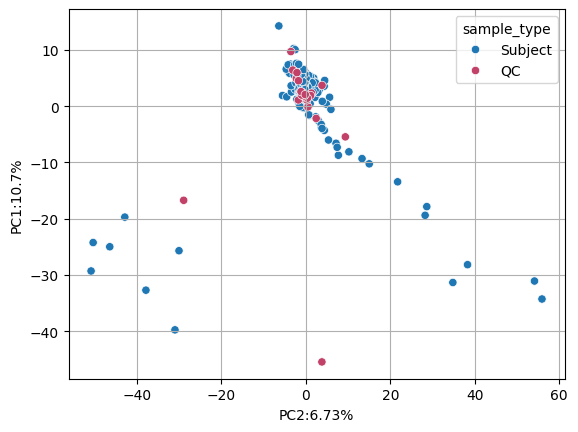

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
pca = PCA(n_components=2)

pca_df = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(results)),index=results.index,columns=["PC1","PC2"])

pca_df["sample_type"] = M['sample_type']


sns.scatterplot(pca_df[pca_df['sample_type'] == 'Subject'],x='PC1',y='PC2',hue='sample_type')
sns.scatterplot(pca_df[pca_df['sample_type'] != 'Subject'],x='PC1',y='PC2',hue='sample_type',palette='flare')
plt.xlabel(f"PC2:{np.round(pca.explained_variance_ratio_[1] * 100,2)}%")
plt.ylabel(f"PC1:{np.round(pca.explained_variance_ratio_[0] * 100,2)}%")
plt.grid(True)